<a href="https://colab.research.google.com/github/neupane11/AI-sneupane/blob/main/chatbot_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep Learning ChatBot**

In this project, I am going to build ChatBot using seq2seq model or encoder-decoder model in TensorFlow. The objective of the model is manuplating given dataset to make a simple chat bot.

**What is Seq2Seq model**



Seq2Seq is a method of encoder-decoder based machine translation and language processing that maps an input of sequence to an output of sequence with a tag and attention value. The idea is to use 2 RNNs that will work together with a special token and try to predict the next state sequence from the previous sequence. 



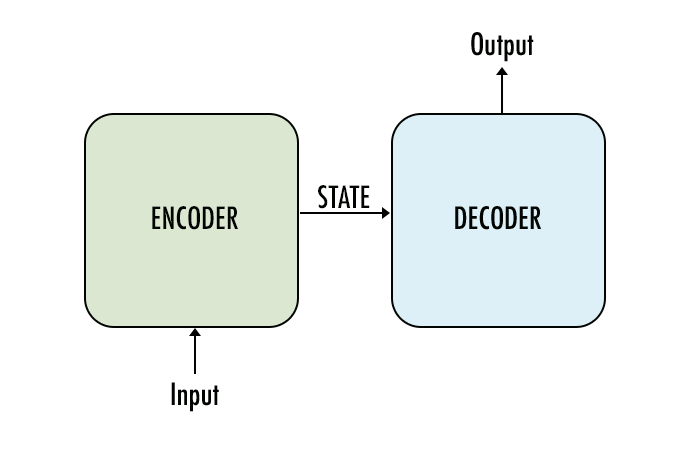

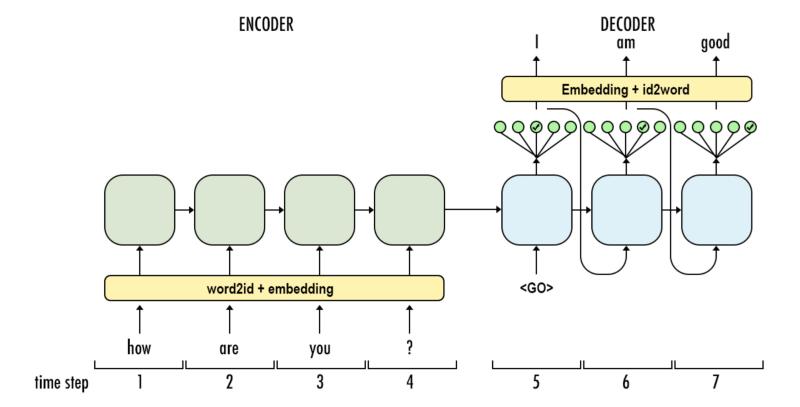

**Get the Data**

I am using Cornel movie data. Availabe [Here](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)

In [5]:
lines=open('/content/drive/MyDrive/cornelldataset/movie_lines.txt',encoding='utf-8',errors='ignore').read().split('\n')
convers=open('/content/drive/MyDrive/cornelldataset/movie_conversations.txt',encoding='utf-8',errors='ignore').read().split('\n')


In [6]:
import re
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from keras.utils.vis_utils import plot_model
import numpy as np


**About the data**

The cornell movie dataset contains two files. The conversation file contains contais the whole converstion of given ID and lines file contains the Id and dialog.

In [7]:
len(lines)

304714

In [8]:
len(convers)

83098

**PreProcess data**


* 


In [9]:
exchn = []
for conver in convers:
  
    exchn.append(conver.split(' +++$+++ ')[-1][1:-1].replace("'", "").replace(",","").split())

diag = {}
for line in lines:
    diag[line.split(' +++$+++ ')[0]] = line.split(' +++$+++ ')[-1]

questions = []
answers = []

for conver in exchn:

  for i in range(len(conver) - 1):

      questions.append(diag[conver[i]])
      answers.append(diag[conver[i+1]])

#max length of 13
sorted_ques = []
sorted_ans = []
for i in range(len(questions)):
    if len(questions[i]) < 13:
        sorted_ques.append(questions[i])
        sorted_ans.append(answers[i])

def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

clean_ques = []
clean_ans = []

for line in sorted_ques:
    clean_ques.append(clean_text(line))
        
for line in sorted_ans:
    clean_ans.append(clean_text(line))

for i in range(len(clean_ans)):
    clean_ans[i] = ' '.join(clean_ans[i].split()[:11])

#since data is big we will only take its portion
## trimming
clean_ans=clean_ans[:80000]
clean_ques=clean_ques[:80000]

#count occurences 
word2count = {}

for line in clean_ques:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
for line in clean_ans:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

#remove less frequent frequent word
thresh = 5
vocab = {}
word_num = 0
for word, count in word2count.items():
    if count >= thresh:
        vocab[word] = word_num
        word_num += 1
 
 # Add the Special tokens
for i in range(len(clean_ans)):
    clean_ans[i] = '<SOS> ' + clean_ans[i] + ' <EOS>'

tokens = ['<PAD>', '<EOS>', '<UNKN>', '<SOS>']
x = len(vocab)
for token in tokens:
    vocab[token] = x
    x += 1
    
vocab['cameron'] = vocab['<PAD>']
vocab['<PAD>'] = 0

#inv answers dict
inv_vocab = {w:v for v, w in vocab.items()}


encoder_inp = []
for line in clean_ques:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<UNKN>'])
        else:
            lst.append(vocab[word])
        
    encoder_inp.append(lst)

decoder_inp = []
for line in clean_ans:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<UNKN>'])
        else:
            lst.append(vocab[word])        
    decoder_inp.append(lst)



encoder_inp = pad_sequences(encoder_inp, 13, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, 13, padding='post', truncating='post')




decoder_final_output = []
for i in decoder_inp:
    decoder_final_output.append(i[1:]) 



decoder_final_output = pad_sequences(decoder_final_output, 13, padding='post', truncating='post')

decoder_final_output = to_categorical(decoder_final_output, len(vocab))

#split data into train and test
encoder_inp_train = encoder_inp[:50000]
decoder_inp_train=decoder_inp[:50000]

encoder_inp_test=encoder_inp[50000:]
decoder_inp_test=decoder_inp[50000:]
x_test=[encoder_inp_test,decoder_inp_test]
decoder_final_output=decoder_final_output[:50000]
y_train=decoder_final_output
y_test=decoder_final_output[50000:]


**Build the Neural Network**

We will build a special kind of model called 'sequence to sequence' (seq2seq in short). You can separate the entire model into 2 small sub-models. The first sub-model is called as [E] Encoder, and the second sub-model is called as [D] Decoder. [E] takes a raw input text data just like any other RNN architectures do. At the end, [E] outputs a neural representation. This is a very typical work, but you need to pay attention what this output really is. The output of [E] is going to be the input data for [D].

That is why we call [E] as Encoder and [D] as Decoder. [E] makes an output encoded in neural representational form, and we don't know what it really is. It is somewhat encrypted. [D] has the ability to look inside the [E]'s output, and it will create a totally different output data (Bot answer in this case).

In [10]:



enc_inp = Input(shape=(13, ))


#Embading layer
VOCAB_SIZE = len(vocab)
embed = Embedding(VOCAB_SIZE+1, output_dim=50, 
                  input_length=13,
                  trainable=True                  
                  )

#encoder LSTM Layer
enc_embed = embed(enc_inp)
enc_lstm = LSTM(400, return_sequences=True, return_state=True)
enc_op, h, c = enc_lstm(enc_embed)
enc_states = [h, c] #enc_states is input for decoder 

dec_inp = Input(shape=(13, ))
#Decoder LSTM Layer
dec_embed = embed(dec_inp)
dec_lstm = LSTM(400, return_sequences=True, return_state=True)
dec_op, _, _ = dec_lstm(dec_embed, initial_state=enc_states)


#dense Layer
dense = Dense(VOCAB_SIZE, activation='softmax')
dense_op = dense(dec_op)

#Create model
model = Model([enc_inp, dec_inp], dense_op)

#compile model
model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')

#plot the model
plot_model(model, to_file='model.png', show_shapes=True)


#Train model on our preprocess data
#this model is used to build encoder and decoder
#model.fit([encoder_inp, decoder_inp],decoder_final_output,epochs=20)
model.fit([encoder_inp_train, decoder_inp_train],y_train,epochs=100)

#saving the model
model.save("/content/drive/MyDrive/seq2seq _Model")


  



Epoch 1/100
982/982 [==============================] - 47s 14ms/step - loss: 3.5042 - acc: 0.4618
Epoch 2/100
982/982 [==============================] - 13s 13ms/step - loss: 2.7847 - acc: 0.5284
Epoch 3/100
982/982 [==============================] - 13s 13ms/step - loss: 2.6227 - acc: 0.5403
Epoch 4/100
982/982 [==============================] - 13s 13ms/step - loss: 2.5347 - acc: 0.5465
Epoch 5/100
982/982 [==============================] - 13s 13ms/step - loss: 2.4750 - acc: 0.5497
Epoch 6/100
982/982 [==============================] - 13s 14ms/step - loss: 2.4259 - acc: 0.5527
Epoch 7/100
982/982 [==============================] - 13s 13ms/step - loss: 2.3655 - acc: 0.5564
Epoch 8/100
982/982 [==============================] - 13s 13ms/step - loss: 2.3093 - acc: 0.5600
Epoch 9/100
982/982 [==============================] - 13s 14ms/step - loss: 2.2699 - acc: 0.5624
Epoch 10/100
982/982 [==============================] - 13s 13ms/step - loss: 2.2239 - acc: 0.5629
Epoch 11/100
982/98

INFO:tensorflow:Assets written to: /content/drive/MyDrive/seq2seq _Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/seq2seq _Model/assets


**Inference**

After training our model with the dataset which would be having the actual translation of the english sentences it is our turn to generate the translations in real time. This time we wont be having the real translation, so the output of the previous timestep goes as the input to the decoder. The inference is continued till we have reached the maximum number of words or any customized stop condition

982/982 [==============================] - 16s 14ms/step - loss: 0.6117 - acc: 0.8597


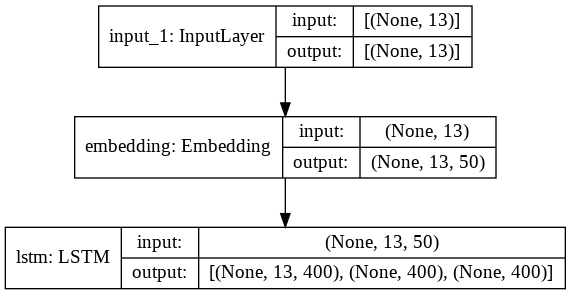

In [11]:
#Inference  To talk to chatbot
#loading model
from tensorflow import keras
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/seq2seq _Model")

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.fit([encoder_inp_train, decoder_inp_train],y_train)

#Encoder Model 
enc_model = Model([enc_inp], enc_states)



# decoder Model
decoder_state_input_h = Input(shape=(400,))
decoder_state_input_c = Input(shape=(400,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_outputs, state_h, state_c = dec_lstm(dec_embed , 
                                    initial_state=decoder_states_inputs)


decoder_states = [state_h, state_c]


dec_model = Model([dec_inp]+ decoder_states_inputs,
                                      [decoder_outputs]+ decoder_states)


plot_model(enc_model, to_file='encoder_model.png', show_shapes=True)


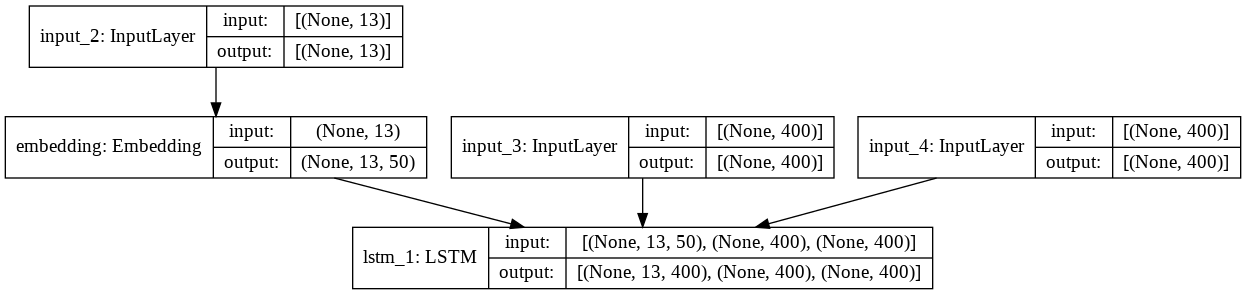

In [12]:
plot_model(dec_model, to_file='decoder_model.png', show_shapes=True)

**Implementation**

In [13]:
print("##########################################")
print("#       Welcome to Chatbot        #")
print("##########################################")


prepro1 = ""
while prepro1 != 'q':
    prepro1  = input("you : ")
    ## prepro1 = "Hello"

    prepro1 = clean_text(prepro1)
    ## prepro1 = "hello"

    prepro = [prepro1]
    ## prepro1 = ["hello"]

    txt = []
    for x in prepro:
        # x = "hello"
        lst = []
        for y in x.split():
            ## y = "hello"
            try:
                lst.append(vocab[y])
                ## vocab['hello'] = 454
            except:
                lst.append(vocab['<UNKN>'])
        txt.append(lst)

    ## txt = [[454]]
    txt = pad_sequences(txt, 13, padding='post')

    ## txt = [[454,0,0,0,.........13]]

    stat = enc_model.predict( txt )

    empty_target_seq = np.zeros( ( 1 , 1) )
     ##   empty_target_seq = [0]


    empty_target_seq[0, 0] = vocab['<SOS>']
    ##    empty_target_seq = [255]

    flag = False
    decoded_translation = ''

    while not flag :

        dec_outputs , h, c= dec_model.predict([ empty_target_seq] + stat )
        decoder_concat_input = dense(dec_outputs)
        ## decoder_concat_input = [0.1, 0.2, .4, .0, ...............]#these are probability of each word provided by softmax function

        sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] ) #This takes value with max probability
        ## sampled_word_index = [2]

        sampled_word = inv_vocab[sampled_word_index] + ' '

        ## inv_vocab[2] = 'hi'
        ## sampled_word = 'hi '

        if sampled_word != '<EOS> ':
            decoded_translation += sampled_word  

        if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 13:
            flag = True 
        #resetting variables
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        ## <SOS> - > hi
        ## hi --> <EOS>
        stat = [h, c]  

    print("Bot : ", decoded_translation )
    print("==============================================")  

##########################################
#       Welcome to Chatbot        #
##########################################
you : hi


Bot :  hi 
you : what is your name
Bot :  <UNKN> you <UNKN> they could <UNKN> <UNKN> in 
you : are you ok?
Bot :  i am fine thank you 
you : how is weather?
Bot :  fine 
you : do you wanna go out?
Bot :  no not really <UNKN> 
you : bye
Bot :  bye 
you : wanna have coffee?
Bot :  no i am serious you are really much 


KeyboardInterrupt: ignored